In [1]:
'''
!wget https://zenodo.org/record/5046428/files/background_for_training.h5
!wget https://zenodo.org/record/7152590/files/Ato4l_lepFilter_13TeV_filtered.h5
!wget https://zenodo.org/record/7152599/files/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
!wget https://zenodo.org/record/7152614/files/hToTauTau_13TeV_PU20_filtered.h5
!wget https://zenodo.org/record/7152617/files/hChToTauNu_13TeV_PU20_filtered.h5
'''

'\n!wget https://zenodo.org/record/5046428/files/background_for_training.h5\n!wget https://zenodo.org/record/7152590/files/Ato4l_lepFilter_13TeV_filtered.h5\n!wget https://zenodo.org/record/7152599/files/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5\n!wget https://zenodo.org/record/7152614/files/hToTauTau_13TeV_PU20_filtered.h5\n!wget https://zenodo.org/record/7152617/files/hChToTauNu_13TeV_PU20_filtered.h5\n'

In [1]:
import argparse

import h5py
import numpy as np
from sklearn.model_selection import train_test_split


def create_datasets_dense(
    bkg_file,
    output_bkg_name,
    signals_files,
    output_signal_names,
    events=70_00_000,
    test_size=0.2,
    val_size=0.2,
    input_shape=57,
    folder="",
):

    # read BACKGROUND data
    with h5py.File(bkg_file, "r") as file:
        full_data = file["Particles"][:, :, :-1]
        #print(full_data.shape)
        np.random.shuffle(full_data)
        if events:
            full_data = full_data[:events, :, :]

    # define training, test and validation datasets
    X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
    X_train, X_val = train_test_split(X_train, test_size=val_size)

    del full_data

    # flatten the data for model input
    X_train = X_train.reshape(X_train.shape[0], input_shape)
    X_test = X_test.reshape(X_test.shape[0], input_shape)
    X_val = X_val.reshape(X_val.shape[0], input_shape)
    X_train.shape
    with h5py.File(output_bkg_name + "_dataset.h5", "w") as h5f:
        h5f.create_dataset("X_train", data=X_train,compression='gzip')#, chunks=True) 
        h5f.create_dataset("X_test", data=X_test,compression='gzip')#, chunks=True)
        h5f.create_dataset("X_val", data=X_val,compression='gzip')#, chunks=True)
    del X_train, X_val, X_test
    if signals_files:
        # read SIGNAL data
        for i, signal_file in enumerate(signals_files):
            f = h5py.File(signal_file, "r")
            signal_data = f["Particles"][:, :, :-1]
            signal_data = signal_data.reshape(signal_data.shape[0], input_shape)
            with h5py.File(output_signal_names[i] + "_dataset.h5", "w") as h5f2:
                h5f2.create_dataset("Data", data=signal_data,compression='gzip')#, chunks=True)
            del signal_data
    return

create_datasets_dense(
    bkg_file="background_for_training.h5",
    output_bkg_name="BKG",
    signals_files=[
	"Ato4l_lepFilter_13TeV_filtered.h5",
	"hChToTauNu_13TeV_PU20_filtered.h5",
	"hToTauTau_13TeV_PU20_filtered.h5",
	"leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5",
    ],
    output_signal_names=[
	"Ato4l_lepFilter_13TeV",
	"hChToTauNu_13TeV_PU20",
	"hToTauTau_13TeV_PU20",
	"leptoquark_LOWMASS_lepFilter_13TeV",
    ],
)


(3937500, 57)
(1750000, 57)
(1312500, 57)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 24)           1368        ['input_2[0][0]']                
                                                                                                  
 activation_8 (Activation)      (None, 24)           0           ['dense_8[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 16)           384         ['activation_8[0][0]']           
                                                  

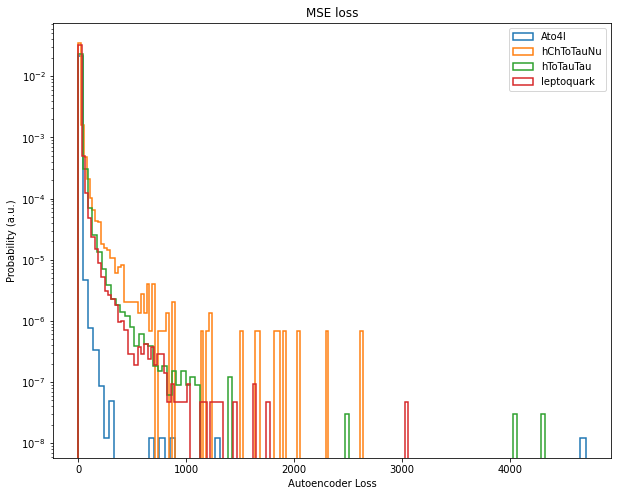

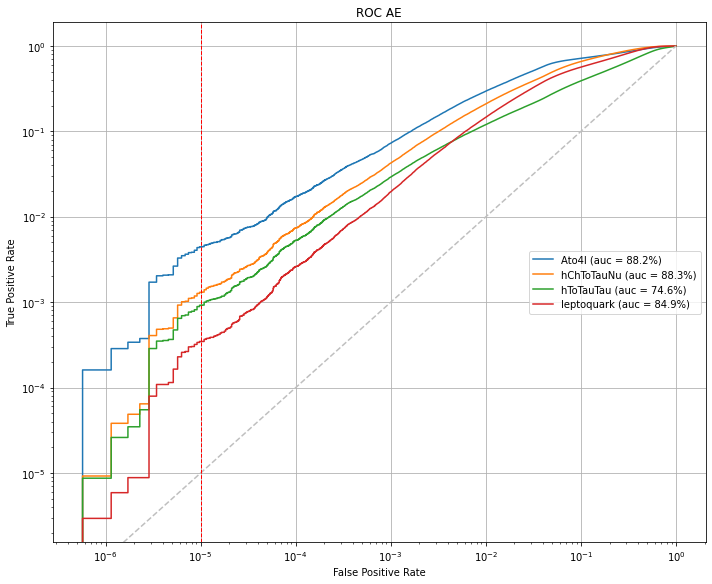

In [3]:
#!/usr/bin/env python


from __future__ import annotations

import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils.vis_utils import plot_model
from sklearn.metrics import auc, roc_curve
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import GlorotUniform

# from tensorflow.keras.layers import   # LeakyReLU,; ReLU,
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Dense,
    Input,
    Layer,
)
from tensorflow.keras.models import Model

folder = ""# "../processed-dataset/"
filename = "BKG_dataset.h5"


with h5py.File(folder + filename, "r") as file:
    X_train = np.array(file["X_train"])
    X_test = np.array(file["X_test"])
    X_val = np.array(file["X_val"])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
# In[8]:


input_shape = 57
latent_dimension = 6
num_nodes = [24, 16, 10]  # [25,15]#
EPOCHS = 10
BATCH_SIZE = 2048
activation = "LeakyReLU"  # LeakyReLU


# In[16]:


initializer = tf.keras.initializers.GlorotUniform()
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False, kernel_initializer=initializer)(inputArray)
x = Activation(activation)(x)
x = Dense(num_nodes[1], use_bias=False, kernel_initializer=initializer)(x)
x = Activation(activation)(x)
#x = Dense(num_nodes[2], use_bias=False, kernel_initializer=initializer)(x)
#x = Activation(activation)(x)
x = Dense(latent_dimension, use_bias=False, kernel_initializer=initializer)(x)
x = Activation(activation)(x)
encoder_1 = Dense(latent_dimension - 3, use_bias=False, kernel_initializer=initializer)(x)
encoder_act1 = Activation("linear")(encoder_1)
encoder_2 = Dense(latent_dimension - 2, use_bias=False, kernel_initializer=initializer)(x)
encoder_act2 = Activation("linear")(encoder_2)


# decoder
merged = Concatenate()([encoder_act1, encoder_act2])
x = Activation(activation)(merged)
#x = Dense(num_nodes[2], use_bias=False, kernel_initializer=initializer)(x)
#x = Activation(activation)(x)
x = Dense(num_nodes[1], use_bias=False, kernel_initializer=initializer)(x)
x = Activation(activation)(x)
x = Dense(num_nodes[0], use_bias=False, kernel_initializer=initializer)(x)
x = Activation(activation)(x)
decoder = Dense(input_shape)(x)

# create autoencoder
autoencoder = Model(inputs=inputArray, outputs=decoder)
autoencoder.summary()

plot_model(
    autoencoder, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

# In[17]:


autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss="mse",
    #metrics=['AUC','ACC'],  # , "AUC"]
)  # ,metrics=['AUC','ACC','MSE']) #loss= "mse", mae, msle MeanSquaredLogarithmicError mean_squared_logarithmic_error


# In[18]:


callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.002,
    patience=10,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

#X_train = X_train[:1000,:]

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    #callbacks=callbacks
)
del X_train
del X_val

# In[19]:


# model_name = "model_name"
# model_directory = ""
# save_model(model_directory + model_name, autoencoder)

# ## Prediction - background

bkg_prediction = autoencoder.predict(X_test)

# add correct signal labels
signal_labels = ["Ato4l", "hChToTauNu", "hToTauTau", "leptoquark"]

# add correct path to signal files
signals_file = [
    "Ato4l_lepFilter_13TeV_dataset.h5",
    "hChToTauNu_13TeV_PU20_dataset.h5",
    "hToTauTau_13TeV_PU20_dataset.h5",
    "leptoquark_LOWMASS_lepFilter_13TeV_dataset.h5",
]


# In[ ]:


signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(folder + signals_file[i], "r") as file:
        test_data = np.array(file["Data"])
    signal_data.append(test_data)
    # signal_data = scaler.transform(signal_data)


# In[ ]:


signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i])
    signal_results.append(
        [label, signal_data[i], signal_prediction]
    )  # save [label, true, prediction] for signal


# In[ ]:


def mse_loss(true, prediction):
    # loss = tf.reduce_mean(tf.math.abs(1-tf.math.log(true - prediction)), axis=-1)
    loss = tf.reduce_mean(tf.math.square(true - prediction), axis=-1)
    # loss = - tf.reduce_mean(tf.math.log(1-(tf.math.square(true - prediction))),axis=-1)
    return loss


# In[ ]:


# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(
        mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy()
    )
print(total_loss)
bin_size = 100


plt.figure(figsize=(10, 8))
for i, label in enumerate(signal_labels):
    plt.hist(
        total_loss[i],
        bins=bin_size,
        label=label,
        density=True,
        histtype="step",
        fill=False,
        linewidth=1.5,
    )
plt.yscale("log")
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title("MSE loss")
plt.legend(loc="best")
plt.show()


labels = np.concatenate([["Background"], np.array(signal_labels)])


"""
plt.plot(autoencoder.history.history["loss"], label="Training loss")
plt.plot(autoencoder.history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

plt.plot(autoencoder.history.history["ACC"], label="Training accuracy")
plt.plot(autoencoder.history.history["val_ACC"], label="Validation accuracy")
plt.legend()
plt.show()

"""

target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    if i == 0:
        continue  # background events

    trueVal = np.concatenate(
        (np.ones(total_loss[i].shape[0]), target_background)
    )  # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    for j in range(len(fpr_loss)):
        if fpr_loss[j] == 0.00001:
            print(label, tpr_loss[j])

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(
        fpr_loss,
        tpr_loss,
        "-",
        label=f"{label} (auc = {auc_loss * 100.0:.1f}%)",
        linewidth=1.5,
    )

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="center right")
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", color="0.75")
plt.axvline(
    0.00001, color="red", linestyle="dashed", linewidth=1
)  # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()


# ##